# Compute Cl on galaxy overdensities on DC2-Data

- author : Sylvie Dagoret-Campagne
- affliliation : IJCLab/in2p3/CNRS
- creation date : July 28th 2020


- Run on Spark cluster


In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pyarrow

In [3]:
pyarrow.__version__

'0.14.1'

In [4]:
from pyspark import SparkContext
import pyspark
sc = SparkContext (
   "local", 
   "storagelevel app"
)

In [5]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=local appName=storagelevel app>
2.4.4


In [6]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [7]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [8]:
npix = hp.nside2npix(nside)
lmax = 3 * nside

In [9]:
def Ang2Pix_func(ra: pd.Series, dec: pd.Series) -> pd.Series:
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

In [10]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
#gal = gal.withColumn("ihealpix",pd_ang2pix(gal["RA"],gal["DEC"]))

## Get parquet files


In [11]:
! hadoop dfs -ls /lsst/DC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 18 items
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-06-12 10:23 /lsst/DC2/DR6axCdc2.parquet
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-04-23 17:15 /lsst/DC2/cosmoDC2
-rw-r--r--   3 stephane.plaszczynski lsst 83486737444 2020-05-28 19:33 /lsst/DC2/dc2_object_run2.2i_dr3.parquet
-rw-r--r--   3 stephane.plaszczynski lsst 44384598496 2020-06-05 13:15 /lsst/DC2/dc2_object_run2.2i_dr6.parquet
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-06-26 10:36 /lsst/DC2/dc2_object_run2.2i_dr6b
drwxr-xr-x   - stephane.plaszczynski lsst           0 2020-07-28 18:46 /lsst/DC2/dc2_object_run2.2i_dr6c
drwxr-xr-x   - stephane.plaszczynski lsst           0 2019-10-21 15:54 /lsst/DC2/df1.parquet
drwxr-xr-x   - stephane.plaszczynski lsst           0 2019-11-08 16:58 /lsst/DC2/df2.parquet
drwxr-xr-x   - stephane.plaszczynski lsst           0 2019-12-06 18:

In [12]:
! hadoop dfs -ls /lsst/DC2/dc2_object_run2.2i_dr6c

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 165 items
-rw-r--r--   3 stephane.plaszczynski lsst      85470 2020-07-28 18:18 /lsst/DC2/dc2_object_run2.2i_dr6c/dc2_object_run2.2i_dr6c_tract2723.parquet
-rw-r--r--   3 stephane.plaszczynski lsst     155274 2020-07-28 18:18 /lsst/DC2/dc2_object_run2.2i_dr6c/dc2_object_run2.2i_dr6c_tract2724.parquet
-rw-r--r--   3 stephane.plaszczynski lsst     132923 2020-07-28 18:18 /lsst/DC2/dc2_object_run2.2i_dr6c/dc2_object_run2.2i_dr6c_tract2725.parquet
-rw-r--r--   3 stephane.plaszczynski lsst     137159 2020-07-28 18:18 /lsst/DC2/dc2_object_run2.2i_dr6c/dc2_object_run2.2i_dr6c_tract2726.parquet
-rw-r--r--   3 stephane.plaszczynski lsst     161178 2020-07-28 18:18 /lsst/DC2/dc2_object_run2.2i_dr6c/dc2_object_run2.2i_dr6c_tract2727.parquet
-rw-r--r--   3 stephane.plaszczynski lsst     121803 2020-07-28 18:18 /lsst/DC2/dc2_object_run2.2i_dr6c/dc2_object_run2.2i_dr6c_tract2728.parquet


### Read files with spark

In [13]:
FLAG_ONE_FILE_INPUT = True

In [14]:
datafile="/lsst/DC2/dc2_object_run2.2i_dr6.parquet"

In [15]:
base_dir="/lsst/DC2/dc2_object_run2.2i_dr6c"

In [16]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

In [17]:
# Read the data as DataFrame
if FLAG_ONE_FILE_INPUT:
    df = spark.read.format("parquet").load(datafile)
else: # read all files
    the_list_of_files=os.listdir(base_dir)
    the_sorted_list_of_files=sorted(the_list_of_files)
    print("sorted files : ",the_sorted_list_of_files[:5])
    selected_files=[]
    for filename in the_sorted_list_of_files:
        sel_filename=re.findall("^dc2_object_run2.2i_dr6c_tract[0-9][0-9][0-9][0-9].parquet$",filename)
        if len(sel_filename) > 0:
            selected_files.append(sel_filename[0])
    print("selected files : ", selected_files[:5])
    InputPath = [base_dir + "/{}".format(filename) for filename in selected_files]
    df = spark.read.parquet(*InputPath)        

In [18]:
df = df.repartition(df.rdd.getNumPartitions())

### DC2 Object catalog Schema

In [19]:
# Check what we have in the file
df.printSchema()

root
 |-- objectId: long (nullable = true)
 |-- tract: long (nullable = true)
 |-- Ixy_g: double (nullable = true)
 |-- IxyPSF: double (nullable = true)
 |-- xErr: float (nullable = true)
 |-- psFlux_flag_g: boolean (nullable = true)
 |-- psFlux_y: double (nullable = true)
 |-- magerr_y_cModel: double (nullable = true)
 |-- blendedness: double (nullable = true)
 |-- psFluxErr_g: double (nullable = true)
 |-- mag_r_cModel: double (nullable = true)
 |-- magerr_i: double (nullable = true)
 |-- xy_flag: boolean (nullable = true)
 |-- Ixy: double (nullable = true)
 |-- psFlux_u: double (nullable = true)
 |-- Iyy_g: double (nullable = true)
 |-- cModelFlux_g: double (nullable = true)
 |-- cModelFluxErr_y: double (nullable = true)
 |-- ra: double (nullable = true)
 |-- cModelFluxErr_z: double (nullable = true)
 |-- psFluxErr_i: double (nullable = true)
 |-- mag_u: double (nullable = true)
 |-- magerr_z_cModel: double (nullable = true)
 |-- psFlux_flag_z: boolean (nullable = true)
 |-- mag_u_c

In [20]:
df_gal=df.filter('extendedness == true')

In [21]:
# Show all available tracts
df_gal.select('tract').distinct().show()

+-----+
|tract|
+-----+
| 2906|
| 3452|
| 3640|
| 2900|
| 3076|
| 3636|
| 2908|
| 4860|
| 3262|
| 3444|
| 2903|
| 3080|
| 3267|
| 3631|
| 3261|
| 5073|
| 2898|
| 3446|
| 3641|
| 4648|
+-----+
only showing top 20 rows



In [22]:
df_stat=df_gal.groupBy("tract").count()

In [23]:
df_stat.show()

+-----+------+
|tract| count|
+-----+------+
| 2906|761182|
| 3452|785896|
| 3640|803361|
| 2900|814598|
| 3076|819004|
| 3636|869495|
| 2908|652452|
| 4860| 28823|
| 3262|819267|
| 3444|831455|
| 2903|794176|
| 3080|823202|
| 3267|775054|
| 3631|247479|
| 3261|764896|
| 5073| 56896|
| 2898|807443|
| 3446|849913|
| 3641|811200|
| 4648|551923|
+-----+------+
only showing top 20 rows



In [24]:
dp_stat=df_stat.toPandas()
dp_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
tract    78 non-null int64
count    78 non-null int64
dtypes: int64(2)
memory usage: 1.3 KB


In [25]:
indexes=np.arange(len(dp_stat))

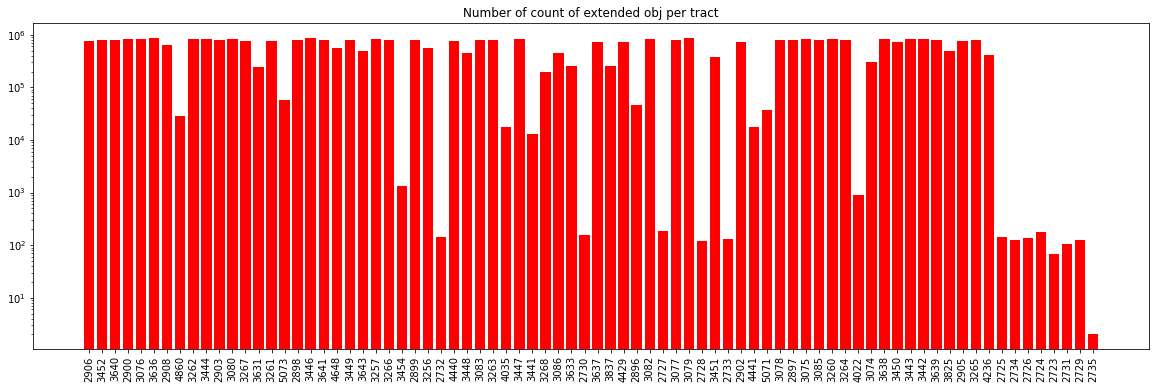

In [26]:
width=0.8
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
ax.bar(indexes,dp_stat["count"].values,width,color='red')
ax.set_xticks(indexes)
ax.set_title("Number of count of extended obj per tract")
xtickNames = ax.set_xticklabels(dp_stat["tract"].values)
plt.setp(xtickNames, rotation=90, fontsize=10)
plt.yscale('log')

The DM stack includes functionality to get the tract and patch number corresponding to a certain position `(RA,DEC)`. However, it is out of the scope of this tutorial.

Apache Spark provides `filter` mechanisms, which you can use to speed up data access if you only need a certain chunks of the dataset.
For the object catalog, the chunks are broken into `tract` and `patch`, and hence those are the `filters` you can use:

======= tract 2906 ================


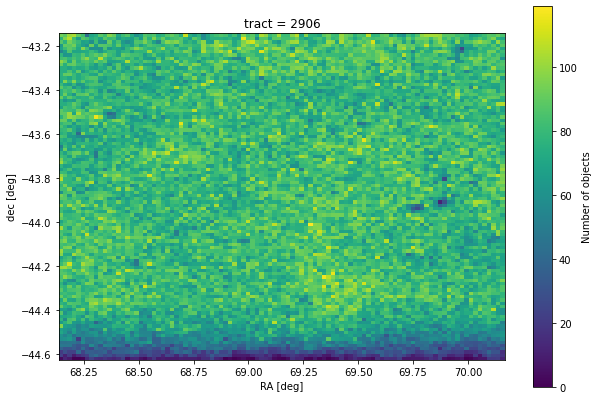

======= tract 3452 ================


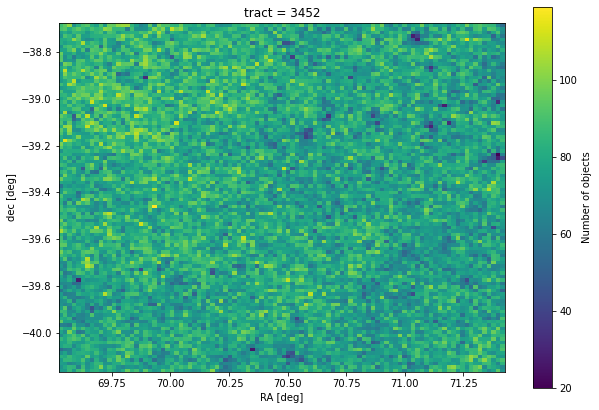

======= tract 3640 ================


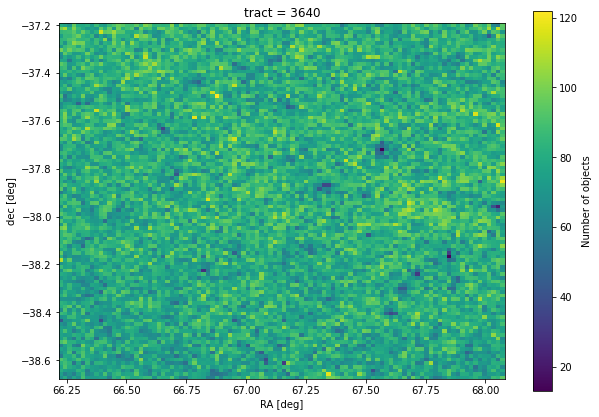

In [27]:
idx=0
for the_tract in dp_stat["tract"].values:
    selection_name = "tract == {}".format(the_tract)

    # Retrieve the ra,dec coordinates of all sources within tract number 4430
    data = df_gal.select('ra', 'dec').where(selection_name).collect()
    #data = df.select('ra', 'dec').collect()
    
    print("======= tract {} ================".format(the_tract))
    #data.describe().show()

    if dp_stat["count"].values[idx]>1e4:
    
        # `collect` returns list of list[ra, dec], so for 
        # plotting purpose we tranpose the output:
        ra, dec = np.transpose(data)

        # Plot a 2d histogram of sources
        plt.figure(figsize=(10,7))
        plt.hist2d(ra, dec, 100)
        plt.gca().set_aspect('equal')
        plt.colorbar(label='Number of objects')
        plt.xlabel('RA [deg]')
        plt.ylabel('dec [deg]');
        plt.title("tract = {}".format(the_tract))
        plt.show()
        
    idx+=1
    if idx>2:
        break

In [28]:
pd_ang2pix = pandas_udf(Ang2Pix_func, returnType=IntegerType())
df_gal_healpix = df_gal.withColumn("ihealpix",pd_ang2pix(df_gal["ra"],df_gal["dec"]))

In [29]:
df_gal_healpix.printSchema()

root
 |-- objectId: long (nullable = true)
 |-- tract: long (nullable = true)
 |-- Ixy_g: double (nullable = true)
 |-- IxyPSF: double (nullable = true)
 |-- xErr: float (nullable = true)
 |-- psFlux_flag_g: boolean (nullable = true)
 |-- psFlux_y: double (nullable = true)
 |-- magerr_y_cModel: double (nullable = true)
 |-- blendedness: double (nullable = true)
 |-- psFluxErr_g: double (nullable = true)
 |-- mag_r_cModel: double (nullable = true)
 |-- magerr_i: double (nullable = true)
 |-- xy_flag: boolean (nullable = true)
 |-- Ixy: double (nullable = true)
 |-- psFlux_u: double (nullable = true)
 |-- Iyy_g: double (nullable = true)
 |-- cModelFlux_g: double (nullable = true)
 |-- cModelFluxErr_y: double (nullable = true)
 |-- ra: double (nullable = true)
 |-- cModelFluxErr_z: double (nullable = true)
 |-- psFluxErr_i: double (nullable = true)
 |-- mag_u: double (nullable = true)
 |-- magerr_z_cModel: double (nullable = true)
 |-- psFlux_flag_z: boolean (nullable = true)
 |-- mag_u_c

In [30]:
df_gal_healpix_small=df_gal_healpix.select('ra','dec','ihealpix')

In [31]:
df_gal_healpix_small.describe().show()

+-------+-----------------+-------------------+-----------------+
|summary|               ra|                dec|         ihealpix|
+-------+-----------------+-------------------+-----------------+
|  count|         39602485|           39602485|         39602485|
|   mean|61.95524277249138|  -40.3390430922766|2588899.512997303|
| stddev|6.986761485183246|  3.079180331414271|66217.04657590392|
|    min|49.49254691350636|-44.642587097415955|          2284935|
|    max|74.21783862260499|-26.938285987904337|          2678580|
+-------+-----------------+-------------------+-----------------+



In [32]:
m=df_gal_healpix_small.groupBy('ihealpix').count()
m.show(5)

+--------+-----+
|ihealpix|count|
+--------+-----+
| 2656941| 4021|
| 2664828| 4223|
| 2656944| 5236|
| 2653021| 5200|
| 2660951| 5309|
+--------+-----+
only showing top 5 rows



In [33]:
#m.orderBy('ihealpix', ascending=True).show(10)

In [34]:
# get to python world (to Pandas) : 
# note that here is the action (lazy evaluation so far)
p=m.toPandas()
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9178 entries, 0 to 9177
Data columns (total 2 columns):
ihealpix    9178 non-null int32
count       9178 non-null int64
dtypes: int32(1), int64(1)
memory usage: 107.7 KB


In [35]:
p

,ihealpix,count
0,2656941,4021
1,2664828,4223
2,2656944,5236
3,2653021,5200
4,2660951,5309
5,2651087,4592
6,2651098,5035
7,2634992,5311
8,2649047,265
9,2630966,5219


/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1194: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/opt/anaconda3-5.2.0/lib/python3.6/site-packages/healpy/projaxes.py:1153: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


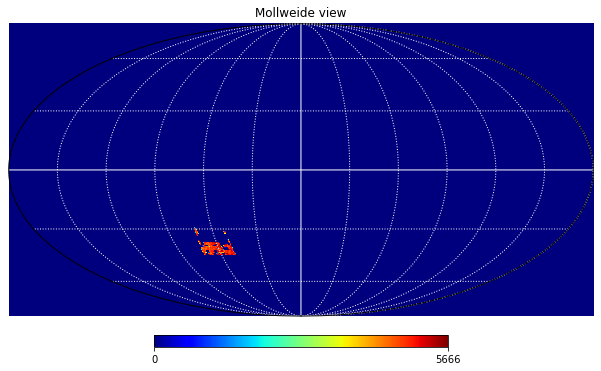

In [36]:
# the following doesn't has anything to do with spark (only Healpix)
hpMap = np.zeros(hp.nside2npix(nside))
#fill the map from the pandas object
hpMap[p['ihealpix'].values]=p['count'].values
#plot using standard healpy function
hp.mollview(hpMap,cmap="jet")
hp.graticule(color='white')

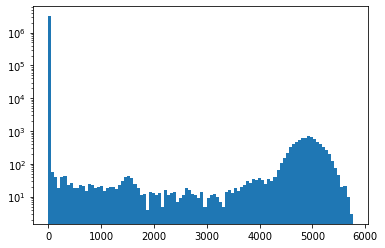

In [37]:

plt.hist(hpMap,bins=int(100))
plt.yscale('log')
plt.show()


In [38]:
cl = hp.anafast(hpMap)
ell = np.arange(len(cl))

Text(0.5, 1.0, 'DC2Run2.2i : $C_\\ell$ by healpix/anafast')

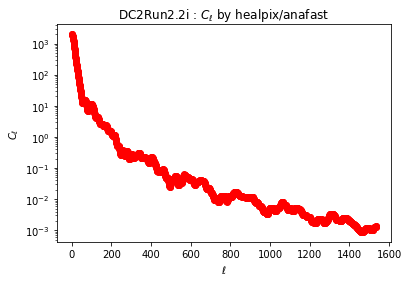

In [39]:
plt.plot(ell,cl,"ro")
plt.yscale('log')
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell$")
plt.title("{} : $C_\ell$ by healpix/anafast".format("DC2Run2.2i"))

In [40]:
lmax 

1536

In [41]:
hpMap.shape

(3145728,)